In [1]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)



Using TensorFlow backend.


In [2]:
data = pd.read_csv("/Users/s0c02nj/Desktop/Class Imbalance/creditcard.csv")
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Considering only 1000 rows of Non Fraud cases

In [3]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

In [4]:
tsne = TSNE(n_components=2, random_state=0)

In [5]:
X_t = tsne.fit_transform(X)

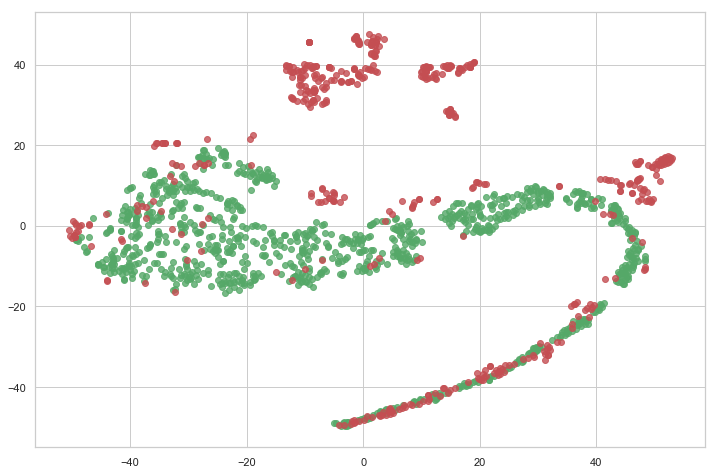

In [8]:
plt.figure(figsize=(12, 8))
plt.scatter(X_t[np.where(Y == 0), 0], X_t[np.where(Y == 0), 1], 
            marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')

plt.scatter(X_t[np.where(Y == 1), 0], X_t[np.where(Y == 1), 1], 
            marker='o', color='r', linewidth='1', alpha=0.8, label='Non Fraud')



We will create an autoencoder model in which we only show the model non-fraud cases. The model will try to learn the best representation of non-fraud cases. The same model will be used to generate the representations of fraud cases and we expect them to be different from non-fraud ones.

Create a network with one input layer and one output layer having identical dimentions ie. the shape of non-fraud cases. We will use keras package.

In [32]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [33]:
autoencoder = Model(input_layer, output_layer)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_10 (Dense)             (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
_________________________________________________________________


In [34]:
autoencoder.compile(optimizer="adadelta", loss="mse")

In [44]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [38]:
#x_fraud.shape
autoencoder.fit(x_norm[0:7000], x_norm[0:7000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Train on 5600 samples, validate on 1400 samples
Epoch 1/10
5600/5600 [==============================] - 0s 13us/step - loss: 0.1230 - val_loss: 0.1165
Epoch 2/10
5600/5600 [==============================] - 0s 13us/step - loss: 0.1238 - val_loss: 0.1169
Epoch 3/10
5600/5600 [==============================] - 0s 13us/step - loss: 0.1245 - val_loss: 0.1175
Epoch 4/10
5600/5600 [==============================] - 0s 13us/step - loss: 0.1260 - val_loss: 0.1176
Epoch 5/10
5600/5600 [==============================] - 0s 11us/step - loss: 0.1266 - val_loss: 0.1171
Epoch 6/10
5600/5600 [==============================] - 0s 10us/step - loss: 0.1276 - val_loss: 0.1172
Epoch 7/10
5600/5600 [==============================] - 0s 11us/step - loss: 0.1281 - val_loss: 0.1171
Epoch 8/10
5600/5600 [==============================] - 0s 10us/step - loss: 0.1287 - val_loss: 0.1184
Epoch 9/10
5600/5600 [==============================] - 0s 11us/step - loss: 0.1296 - val_loss: 0.1178
Epoch 10/10
5600/5600 [==

#### Obtain the Latent Representations
Now, the model is trained. We are intereseted in obtaining latent representation of the input learned by the model. This can be accessed by the weights of the trained model. We will create another network containing sequential layers, and we will only add the trained weights till the third layer where latent representation exists.

In [40]:
#Defining the Intermediate Layer Model
hidden_representation  = Model(inputs=autoencoder.input,outputs=autoencoder.get_layer('dense_9').output)

In [41]:
norm_hid_rep = hidden_representation.predict(x_norm[:7000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

In [42]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [43]:
rep_x = tsne.fit_transform(rep_x)

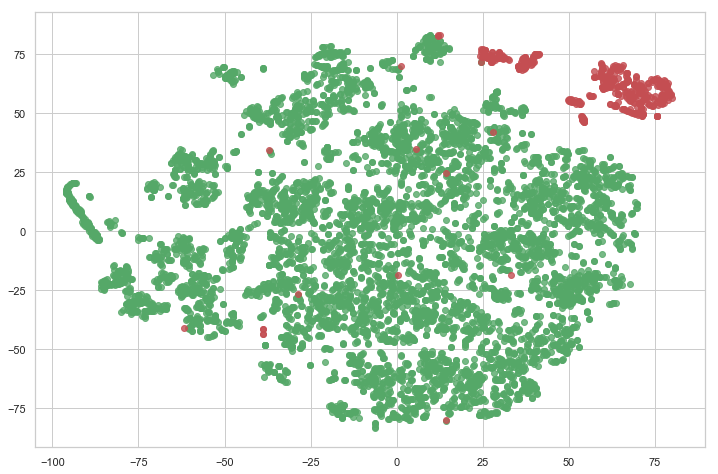

In [45]:
plt.figure(figsize=(12, 8))
plt.scatter(rep_x[np.where(rep_y == 0), 0], rep_x[np.where(rep_y == 0), 1], 
            marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')

plt.scatter(rep_x[np.where(rep_y == 1), 0], rep_x[np.where(rep_y == 1), 1], 
            marker='o', color='r', linewidth='1', alpha=0.8, label='Non Fraud')

